<a href="https://colab.research.google.com/github/Kalebe-Nascimento/Gerador-Tweets/blob/main/geradorTweets_RnR_Kalebe.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Gerando novos tweets do Elon Musk


Usaremos Tweets do Elon Musk, para treinar um modelo, onde a arquitetura deverá ter camadas LSTM e  Densa. O modelo irá gerar tweets automaticamente. o modelo gerado a nível de palavra.

O conjunto de dados está disponível no site de competições em Data Science Kaggle: https://www.kaggle.com/datasets/gpreda/elon-musk-tweets?resource=download&select=elon_musk_tweets.csv 

#Importando bibliotecas

In [79]:
%tensorflow_version 2.x
import tensorflow as tf, numpy as np 
from tensorflow import keras 
from keras import layers 
from keras.preprocessing.text import Tokenizer 
from keras.utils import pad_sequences
from keras.utils import to_categorical 
import pandas as pd
from keras.callbacks import ModelCheckpoint
#
import matplotlib.pyplot as plt
import re, string # expressões regulares
plt.style.use('ggplot')
tf.__version__
from itertools import chain

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


#Exploração da base de dados

In [80]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [81]:
elon_tweets = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/elon_musk_tweets.csv')
elon_tweets.head()

,id,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,retweets,favorites,is_retweet
0,1544379368478212100,Elon Musk,NaN,"Mars & Cars, Chips & Dips",2009-06-02 20:12:29+00:00,101240855,115,13503,True,2022-07-05 17:55:09+00:00,@BillyM2k I find the gold toe sock – inevitabl...,NaN,Twitter for iPhone,335,6542,False
1,1544377493263720450,Elon Musk,NaN,"Mars & Cars, Chips & Dips",2009-06-02 20:12:29+00:00,101240806,115,13503,True,2022-07-05 17:47:42+00:00,"Sock Con, the conference for socks",NaN,Twitter for iPhone,1451,30753,False
2,1544377130590552064,Elon Musk,NaN,"Mars & Cars, Chips & Dips",2009-06-02 20:12:29+00:00,101240806,115,13503,True,2022-07-05 17:46:15+00:00,Always something new for the magazine cover an...,NaN,Twitter for iPhone,1284,28610,False
3,1544375575724400645,Elon Musk,NaN,"Mars & Cars, Chips & Dips",2009-06-02 20:12:29+00:00,101240806,115,13503,True,2022-07-05 17:40:05+00:00,@ExplainThisBob This guy gets it,NaN,Twitter for iPhone,131,3640,False
4,1544375148605853699,Elon Musk,NaN,"Mars & Cars, Chips & Dips",2009-06-02 20:12:29+00:00,101240806,115,13503,True,2022-07-05 17:38:23+00:00,Sock tech is so advanced that you can get pret...,NaN,Twitter for iPhone,1191,23790,False


tirando caracteres especias, deixando todas letras em minusculas e como "texto"

In [82]:
def clean_text(tweets):
   tweets = tweets.lower() #letras minusculas 
   tweets = re.sub('\[.*?\]', '', tweets) #removendo .*?\
   tweets = re.sub('https?://\S+|www\.\S+', '',  tweets) #removendo https?://\S+|www\.\S+
   tweets = re.sub('<.*?>+', '',  tweets) #<.*?>+
   tweets = re.sub('\n', '',  tweets)  #removendo .*?\
   tweets = re.sub('[^\x00-\x7f]', '',tweets) # remove numeros e acentos
   tweets = re.sub("#[A-Za-z0-9_]+","",tweets)
   tweets = re.sub("@[A-Za-z0-9_]+","", tweets)
   tweets = re.sub("&\w+;","", tweets)
   tweets = re.sub('\w*\d\w*', '', tweets)
   tweets = " ".join(filter(lambda x:x[0]!="@", tweets.split()))
   return tweets


In [83]:
(elon_tweets)

,id,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,retweets,favorites,is_retweet
0,1544379368478212100,Elon Musk,NaN,"Mars & Cars, Chips & Dips",2009-06-02 20:12:29+00:00,101240855,115,13503,True,2022-07-05 17:55:09+00:00,@BillyM2k I find the gold toe sock – inevitabl...,NaN,Twitter for iPhone,335,6542,False
1,1544377493263720450,Elon Musk,NaN,"Mars & Cars, Chips & Dips",2009-06-02 20:12:29+00:00,101240806,115,13503,True,2022-07-05 17:47:42+00:00,"Sock Con, the conference for socks",NaN,Twitter for iPhone,1451,30753,False
2,1544377130590552064,Elon Musk,NaN,"Mars & Cars, Chips & Dips",2009-06-02 20:12:29+00:00,101240806,115,13503,True,2022-07-05 17:46:15+00:00,Always something new for the magazine cover an...,NaN,Twitter for iPhone,1284,28610,False
3,1544375575724400645,Elon Musk,NaN,"Mars & Cars, Chips & Dips",2009-06-02 20:12:29+00:00,101240806,115,13503,True,2022-07-05 17:40:05+00:00,@ExplainThisBob This guy gets it,NaN,Twitter for iPhone,131,3640,False
4,1544375148605853699,Elon Musk,NaN,"Mars & Cars, Chips & Dips",2009-06-02 20:12:29+00:00,101240806,115,13503,True,2022-07-05 17:38:23+00:00,Sock tech is so advanced that you can get pret...,NaN,Twitter for iPhone,1191,23790,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4318,1642324054865588228,Elon Musk,A Shortfall of Gravitas,NaN,2009-06-02 20:12:29+00:00,134456433,193,20691,False,2023-04-02 00:32:22+00:00,@PeterDiamandis @drmarkhyman I recommend havin...,NaN,Twitter for iPhone,116,1747,False
4319,1642273756289671170,Elon Musk,A Shortfall of Gravitas,NaN,2009-06-02 20:12:29+00:00,134456433,193,20691,False,2023-04-01 21:12:30+00:00,"@SciGuySpace More than days away, but hopefull...",NaN,Twitter for iPhone,711,9530,False
4320,1642269842555142150,Elon Musk,A Shortfall of Gravitas,NaN,2009-06-02 20:12:29+00:00,134456433,193,20691,False,2023-04-01 20:56:57+00:00,@ashleevance You could literally film a Walkin...,NaN,Twitter for iPhone,13285,65937,False
4321,1642247501108461571,Elon Musk,A Shortfall of Gravitas,NaN,2009-06-02 20:12:29+00:00,134456433,193,20691,False,2023-04-01 19:28:10+00:00,@PeterDiamandis Ok fine AI should do fashion i...,NaN,Twitter for iPhone,527,10657,False


resultado da limpeza

In [84]:
elon_tweets['text'] = elon_tweets['text'].apply(lambda x: clean_text(x))
tweets_text = " \n ".join(elon_tweets['text'])
print(tweets_text)

i find the gold toe sock inevitably off kilter washed out a little troubling esthetically arguably a bit corpo 
 sock con, the conference for socks 
 always something new for the magazine cover and the articles practically write themselves 
 this guy gets it 
 sock tech is so advanced that you can get pretty much anything in sock form these days! 
 i must confess to a penchant for creative socks 
 its time 
 his success was in fact due, in part, because he was super fun at parties, spoke and wrote incredibly well! 
 while bleak posts maybe generate more clicks, more happier moments in history would be nice 
 supporting doge wherever possible 
 moon brought us together in ,mars can do that in the future 
 without a common goal, humanity will fight itself 
 exactly 
 can you say more about this: pressures that the government may have placed on twitter 
 humanity will reach mars in your lifetime 
 flatulence earther 
 maybe later this year 
 zip around vegas super fast with teslas in tunn

numero de caracteres remanecentes

In [85]:
len(tweets_text)

223138

In [86]:
tweets_texts_treated = [w for w in tweets_text.split(' ') if w.strip() != '' or w == '\n']

Quantidade de palavras e as 10 mais usadas

In [87]:
print('Quantidade Total de Palavras: ', len(tweets_texts_treated))
print(tweets_texts_treated[:10]) #palavras mais usadas

Quantidade Total de Palavras:  41590
['i', 'find', 'the', 'gold', 'toe', 'sock', 'inevitably', 'off', 'kilter', 'washed']


# tokenizando 
Criação de um vocabulário, filtro de palavras frequentes e formatar os dados de entrada. Depois, vamos construir e treinar a rede neural LSTM com esses dados.


*   Criar Tokenizer e tokenizar;
*   Criar Subsequências;
*   Codificar cada token usando a estratégia one-hot.

In [88]:
# tamanho do vocabulário

vocab_size = 1000 
tokenizer = Tokenizer(num_words=vocab_size, oov_token='<OOV>',
                      filters='[^\x00-\x7f]')
tokenizer.fit_on_texts(tweets_texts_treated)
tokens = tokenizer.texts_to_sequences(tweets_texts_treated)
flat_list = list(chain(*tokens))
tokens = list(map(int, flat_list))
tokens

[10,
 368,
 3,
 1,
 1,
 1,
 1,
 239,
 1,
 1,
 63,
 6,
 177,
 646,
 1,
 1,
 6,
 426,
 1,
 2,
 1,
 1,
 3,
 1,
 11,
 1,
 2,
 240,
 279,
 113,
 11,
 3,
 1,
 1,
 24,
 3,
 1,
 1,
 393,
 868,
 2,
 13,
 511,
 869,
 15,
 2,
 1,
 1,
 5,
 26,
 1,
 9,
 19,
 58,
 86,
 201,
 62,
 394,
 8,
 1,
 647,
 143,
 1,
 2,
 10,
 213,
 1,
 4,
 6,
 1,
 11,
 1,
 1,
 2,
 29,
 65,
 2,
 117,
 1,
 28,
 8,
 648,
 1,
 8,
 1,
 214,
 77,
 28,
 144,
 427,
 27,
 1,
 1,
 24,
 870,
 871,
 1,
 2,
 241,
 1,
 872,
 85,
 1,
 41,
 1,
 41,
 1,
 1,
 8,
 649,
 59,
 12,
 191,
 2,
 1,
 1,
 1,
 229,
 2,
 1,
 1,
 157,
 1,
 8,
 1,
 58,
 48,
 9,
 8,
 3,
 133,
 2,
 257,
 6,
 873,
 1,
 302,
 14,
 650,
 369,
 2,
 66,
 2,
 58,
 19,
 202,
 41,
 54,
 1,
 1,
 9,
 3,
 258,
 215,
 30,
 1,
 18,
 16,
 2,
 302,
 14,
 512,
 280,
 8,
 50,
 1,
 2,
 1,
 1,
 2,
 85,
 281,
 13,
 149,
 2,
 1,
 470,
 1,
 144,
 395,
 25,
 744,
 8,
 1,
 2,
 1,
 1,
 5,
 3,
 87,
 1,
 1,
 36,
 6,
 1,
 1,
 20,
 15,
 5,
 75,
 100,
 36,
 1,
 2,
 396,
 134,
 1,
 11,
 745,
 1,
 1,
 87

In [89]:
print(tweets_texts_treated[:8])
print(tokens[:8])

['i', 'find', 'the', 'gold', 'toe', 'sock', 'inevitably', 'off']
[10, 368, 3, 1, 1, 1, 1, 239]


Após tokenizar as sentenças, devemos agrupar as palavras para criar as sub-sequencias de entrada(X) e as respectivas saídas, ou seja, as palavras seguintes(Y). Ao fatiar a lista podemos definir um intervalo entre cada sequência (step no código abaixo), isso reduz a produção de sequencias com palavras sobrepostas e repetidas:

In [90]:
step = 1 # distancia a cada fatia 
sentences = [] # frases X
next_words = [] # palavras Y
seq_len = 10 # número de tokens por frase

for i in range(0, len(tokens) - seq_len, step):
    sentences.append(tokens[i: i + seq_len])
    next_words.append(tokens[i + seq_len])

In [91]:
print(f'[+] Instâncias para treino: {len(sentences)}')
for i in range(5):
    print(sentences[i],'-->',next_words[i])

[+] Instâncias para treino: 41782
[10, 368, 3, 1, 1, 1, 1, 239, 1, 1] --> 63
[368, 3, 1, 1, 1, 1, 239, 1, 1, 63] --> 6
[3, 1, 1, 1, 1, 239, 1, 1, 63, 6] --> 177
[1, 1, 1, 1, 239, 1, 1, 63, 6, 177] --> 646
[1, 1, 1, 239, 1, 1, 63, 6, 177, 646] --> 1


O ultimo passo de preprocessamento é codificar cada token usando a estratégia 
one-hot. Após a codificação cada token será representado por um vetor de 500 dimensões (tamanho do vocabulário). 

Shape atual


In [92]:
train_x = np.array(sentences) # pega as sentenças
train_y = np.array(next_words) # pega as palavras seguintes
print('Shape X:',train_x.shape)
print('Shape Y:',train_y.shape)

Shape X: (41782, 10)
Shape Y: (41782,)


Codificando para one-hot


In [93]:
train_x_onehot = to_categorical(train_x, num_classes=vocab_size)
train_y_onehot = to_categorical(train_y, num_classes=vocab_size)

In [94]:
# train_x:(num_exemplos, num_tokens, vocab_size)
print('Shape X após one-hot:',train_x_onehot.shape)
# train_y:(num_exemplos,vocab_size)
print('Shape Y após one-hot:',train_y_onehot.shape)

Shape X após one-hot: (41782, 10, 1000)
Shape Y após one-hot: (41782, 1000)


# Definição e Treino da Rede Recorrente LSTM

In [95]:
model = keras.Sequential([
    layers.Embedding(vocab_size, 80, input_length=seq_len),
    layers.LSTM(128, return_sequences=True),
    layers.LSTM(50),
    layers.Dropout(0.1),
    layers.Dense(vocab_size*0.05),
    layers.Dense(vocab_size, activation='softmax')
])

In [96]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 10, 80)            80000     
                                                                 
 lstm_6 (LSTM)               (None, 10, 128)           107008    
                                                                 
 lstm_7 (LSTM)               (None, 50)                35800     
                                                                 
 dropout_3 (Dropout)         (None, 50)                0         
                                                                 
 dense_6 (Dense)             (None, 50)                2550      
                                                                 
 dense_7 (Dense)             (None, 1000)              51000     
                                                                 
Total params: 276,358
Trainable params: 276,358
Non-tr

Definindo Checkpoints

In [97]:
filepath = "weights-improvement-lstm-{epoch:02d}-{loss:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor = 'loss', verbose = 1, save_best_only = True, mode = 'min')
callbacks_list = [checkpoint]

In [98]:
epocas = 175

Hora de treinar o modelo

In [99]:
%%time
train_history = model.fit(train_x, train_y_onehot, validation_split=0.2,
                    epochs=epocas, batch_size=256, callbacks = callbacks_list)

Epoch 1/175
131/131 [==============================] - ETA: 0s - loss: 0.1247 - accuracy: 0.1737
Epoch 1: loss improved from inf to 0.12474, saving model to weights-improvement-lstm-01-0.1247.hdf5
131/131 [==============================] - 14s 72ms/step - loss: 0.1247 - accuracy: 0.1737 - val_loss: 0.0058 - val_accuracy: 0.2471
Epoch 2/175
131/131 [==============================] - ETA: 0s - loss: 0.0058 - accuracy: 0.2380
Epoch 2: loss improved from 0.12474 to 0.00580, saving model to weights-improvement-lstm-02-0.0058.hdf5
131/131 [==============================] - 3s 19ms/step - loss: 0.0058 - accuracy: 0.2380 - val_loss: 0.0056 - val_accuracy: 0.2471
Epoch 3/175
131/131 [==============================] - ETA: 0s - loss: 0.0057 - accuracy: 0.2380
Epoch 3: loss improved from 0.00580 to 0.00571, saving model to weights-improvement-lstm-03-0.0057.hdf5
131/131 [==============================] - 2s 14ms/step - loss: 0.0057 - accuracy: 0.2380 - val_loss: 0.0056 - val_accuracy: 0.2471
Epoc

Curva de aprendizado em relação a épocas e acuracia

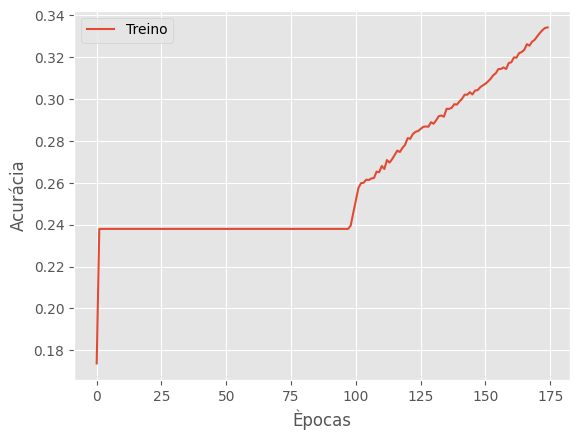

In [100]:
plt.plot(train_history.history['accuracy'], label='Treino')
plt.xlabel('Èpocas');plt.ylabel('Acurácia')
plt.legend()
plt.show()

Criando um modelo e prevendo as proximas frases a partir de uma palavra escolhida

In [101]:
def sample_word(pred_y, temperature=1.0):
    pred_y = pred_y / temperature # 'força' das probabilidades
    pred_token = tf.random.categorical(pred_y, 1).numpy()
    return pred_token # token de saída

In [102]:
seed_text = ['friends'] # frase inicial, pois ele somente consegue gerar a partir de uma palavra existente
next_words = 10 # Quantas palavras a serem geradas

In [103]:

# substitui palavras por tokens
seed_tokens = tokenizer.texts_to_sequences(seed_text)[0] # substitui palavras por tokens
print(seed_text, ' tokenizado fica: ', seed_tokens)
for _ in range(next_words):
    # preenche sequencia com zeros para ter o comprimento adequado pra rede
    tokens_x = pad_sequences([seed_tokens], maxlen=seq_len, )
    # não precisa de one-hot
    # preve probabilidades para a proxima palavra
    pred_y = model.predict(tokens_x)
    # faz amostragem com base nas probabilidades
    next_token = sample_word(pred_y, 0.2)
    next_token = next_token.flatten()[0] # pega valor como um int
    # anexa token a lista
    seed_tokens.append(next_token) 
    
# como a saída é um conjunto de tokens
# realiza a inversão para palavras, usando word_index
resultado = tokenizer.sequences_to_texts([seed_tokens])
print('\n')
print(resultado[0])

['friends']  tokenizado fica:  [524]
1/1 [==============================] - 0s 20ms/step


friends true woke put m sold freedom o burnt billions congratulations
